##Aclaración
El siguiente código ha sido desarrollado por IAUAI y se encuentra con licencia de código abierto, así que siéntete libre de usarlo y modificarlo a tu gusto ✌

Comentarios adicionales:
*   Este código está pensando únicamente para ser corrido en Google Colab con GPU habilitada
*   Se recomienda entrenar por lo mínimo 20 épocas para ver resultados más o menos significativos
*   El código ha sido comentado en algunas partes para facilitar la compresión del mismo

##Descargado de datos

Aquí podrías descargar otros datos que te interesen más.

In [ ]:
from google.colab import output
import os
!git clone https://github.com/StephenMilborrow/muct
%cd ./muct
%mv muct-a-jpg-v1.tar.gz ../
%cd ../
!rm -rf ./muct
!tar xvzf muct-a-jpg-v1.tar.gz
output.clear()
print(len([nombre for nombre in os.listdir('./jpg')]), "imágenes descargadas") #Deberían ser 751

751 imágenes descargadas


##Preprocesamiento de datos

In [ ]:
from PIL import Image
import numpy as np

#Primero hay que cargar todas las imágenes en la RAM
directorio_de_datos_imagenes = './jpg/'
imagenes = [imagen for imagen in os.listdir(directorio_de_datos_imagenes) if ((imagen[-4:] == ".png") or ((imagen[-4:] == ".jpg")))]
print("Hay " + str(len(imagenes)) + " imágenes cargadas")
imagenes_listas = []
for imagen in imagenes:
  imagenes_listas += [Image.open(directorio_de_datos_imagenes+imagen)]
#En segundo lugar hay que ajustar las dimensiones
tamaño_lado = 256
desface_lado = 55 #Esto debería ajustarse si se usan otras imágenes
ancho_original = imagenes_listas[0].width
alto_original = imagenes_listas[0].height
for indice_de_imagen in range(len(imagenes_listas)):  
  imagenes_listas[indice_de_imagen] = imagenes_listas[indice_de_imagen].\
                                      resize((tamaño_lado, round(alto_original*tamaño_lado/ancho_original))).\
                                      crop((0, desface_lado, tamaño_lado, desface_lado + tamaño_lado))
#Lo último es pasar las imágenes a arreglos de Numpy
imagenes_listas_en_arreglos = []
for imagen in imagenes_listas:
  imagenes_listas_en_arreglos += [np.array(imagen)]

Hay 751 imágenes cargadas


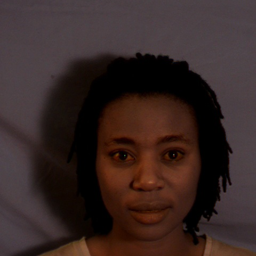

In [ ]:
#Por si quieren ver las imágenes
imagenes_listas[0]

##Generación con modelo GAN

In [ ]:
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
import time
from IPython import display

#Convertimos las imágenes a una dimensión
material_para_entrenar = []
for imagen in imagenes_listas_en_arreglos:
  if (imagen.size == tamaño_lado*tamaño_lado*3):
    material_para_entrenar += [np.reshape(imagen, (-1))]

In [ ]:
#(Esto está basado en: https://github.com/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb)

#Generador
def make_generator_model():
  model = tf.keras.Sequential()
  dropout_var = 0.1
  n_filtro_inicial = 75
  dimesion_inicial = 32
  model.add(tf.keras.layers.Dense(units=n_filtro_inicial*dimesion_inicial*dimesion_inicial, use_bias=False, input_shape=(100,)))
  model.add(keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Reshape(target_shape=(dimesion_inicial, dimesion_inicial, n_filtro_inicial)))
  assert model.output_shape == (None, dimesion_inicial, dimesion_inicial, n_filtro_inicial)
  model.add(tf.keras.layers.Conv2DTranspose(filters=57, kernel_size=3, strides=(2, 2), padding="same", use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(tf.keras.layers.Conv2DTranspose(filters=39, kernel_size=3, strides=(2, 2), padding="same", use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(tf.keras.layers.Conv2DTranspose(filters=21, kernel_size=3, strides=(2, 2), padding="same", use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding="same", use_bias=False, activation="tanh"))
  assert model.output_shape == (None, tamaño_lado, tamaño_lado, 3)
  return model
generator = make_generator_model()
ruido_de_prueba = tf.random.normal([1, 100])
generada_de_prueba = np.asarray(generator(ruido_de_prueba, training=False)[0]*127.5+127.5)
generada_de_prueba = generada_de_prueba.reshape((256, 256, 3))

#Discriminador
def make_discriminator_model():
  dropout_var = 0.1
  n_filtro_final = 75
  model = tf.keras.Sequential()
  model.add(keras.layers.Conv2D(filters=21, kernel_size=3, strides=(2, 2), padding='same', input_shape=[tamaño_lado, tamaño_lado, 3]))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(keras.layers.Conv2D(filters=39, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(keras.layers.Conv2D(filters=57, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(keras.layers.Conv2D(filters=n_filtro_final, kernel_size=3, strides=(2, 2), padding='same'))
  model.add(keras.layers.LeakyReLU())
  model.add(keras.layers.Dropout(dropout_var))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1))
  return model
discriminator = make_discriminator_model()

#Ajustes que son mejor no tocar
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './Checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
                                 generator=generator, discriminator=discriminator)

#Entrenamiento
BUFFER_SIZE = 200
BATCH_SIZE = 10
EPOCAS = 60
noise_dim = 100
num_examples_to_generate = 4
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 7 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('El tiempo tomado en la época {} fue de  {} segundos'.format(epoch + 1, time.time()-start))
  # display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)
  
#Graficador
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(12, 12))
  for i in range(predictions.shape[0]):
      plt.subplot(1, 4, i+1)
      plt.imshow((predictions[i, :, :, :]+1)/2, cmap=None)
      plt.axis('off')
  plt.savefig('image_en_epoca_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
#(Sólo correr si se quiere conocer la semilla para repetirla)
# print(seed)

#(Sólo correr si hay un checkpoint)
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
EPOCAS = 30 #(En caso de que se cambie de opinión respecto al número de épocas)
#Aquí es donde ocurre la magia
train_dataset = [np.asarray((imagen-127.5)/127.5).reshape((1, 256, 256, 3)) for imagen in material_para_entrenar]
train_dataset = np.asarray(train_dataset)
train(train_dataset, EPOCAS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


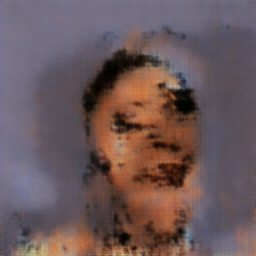

In [ ]:
#Finalmente aquí podemos ver qué puede hacer el modelo entrenado
#(La imagen generada está desordenada y, por eso, debemos arreglarla)
generada_de_prueba_entrenada = np.asarray((generator(ruido_de_prueba, training=False)[0]+1)*127.5)
generada_de_prueba_entrenada = generada_de_prueba_entrenada.reshape((-1)).astype('uint8')
generada_de_prueba_entrenada_R = generada_de_prueba_entrenada[0::3]
generada_de_prueba_entrenada_G = generada_de_prueba_entrenada[1::3]
generada_de_prueba_entrenada_B = generada_de_prueba_entrenada[2::3]
generada_de_prueba_entrenada_R = generada_de_prueba_entrenada_R.reshape((256, 256))
generada_de_prueba_entrenada_G = generada_de_prueba_entrenada_G.reshape((256, 256))
generada_de_prueba_entrenada_B = generada_de_prueba_entrenada_B.reshape((256, 256))

#Para eliminar canales
# generada_de_prueba_entrenada_R = np.asarray([0]*65536)
# generada_de_prueba_entrenada_G = np.asarray([0]*65536)
# generada_de_prueba_entrenada_B = np.asarray([0]*65536)

generación_de_prueba_entrenada = Image.fromarray(\
                                      np.hstack(zip(
                                        generada_de_prueba_entrenada_R.reshape((-1)),\
                                        generada_de_prueba_entrenada_G.reshape((-1)),\
                                        generada_de_prueba_entrenada_B.reshape((-1)))).\
                                          reshape(tamaño_lado, tamaño_lado, 3), 'RGB')
generación_de_prueba_entrenada